In [1]:
import os
import numpy as np
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#압축풀기
import zipfile

local_zip = '/content/drive/MyDrive/데이터저장/manwomandetection.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content/manwomandetection')
zip_ref.close()

# 경로지정하기

In [4]:
#기본경로
base_dir='/content/manwomandetection'

train_dir=os.path.join(base_dir,'train')
val_dir=os.path.join(base_dir,'result')
test_dir=os.path.join(base_dir,'test')

In [5]:
#훈련 이미지 경로
train_man_dir=os.path.join(train_dir,'man')
train_woman_dir=os.path.join(train_dir,'woman')

#validation 이미지 경로
val_man_dir=os.path.join(val_dir,'man')
val_woman_dir=os.path.join(val_dir,'woman')

#test 이미지 경로
test_man_dir=os.path.join(test_dir,'man')
test_woman_dir=os.path.join(test_dir,'woman')

In [6]:
#리스트에 담기
#train
train_man_fnames=os.listdir(train_man_dir)
train_woman_fnames=os.listdir(train_woman_dir)
print(train_man_fnames[:5])

#validation
val_man_fnames=os.listdir(val_man_dir)
val_woman_fnames=os.listdir(val_woman_dir)
print(val_man_fnames[:5])

#test
test_man_fnames=os.listdir(test_man_dir)
test_woman_fnames=os.listdir(test_woman_dir)
print(test_man_fnames[:5])

['177685.jpg.jpg', '118334.jpg.jpg', '097323.jpg.jpg', '110039.jpg.jpg', '100181.jpg.jpg']
['face_269.jpg', 'face_228.jpg', 'face_216.jpg', 'face_214.jpg', 'face_388.jpg']
['072136.jpg.jpg', '073838.jpg.jpg', '070518.jpg.jpg', 'face_116.jpg', '065023.jpg.jpg']


In [7]:
#각 데이터 개수 확인하기
print('train man {}'.format(len(train_man_fnames)))
print('train woman {}'.format(len(train_woman_fnames)))

print('val man {}'.format(len(val_man_fnames)))
print('val woman {}'.format(len(val_woman_fnames)))

print('test man {}'.format(len(test_man_fnames)))
print('test woman {}'.format(len(test_woman_fnames)))

train man 24587
train woman 24037
val man 176
val woman 170
test man 5984
test woman 6011


# 데이터셋/전처리

In [8]:
batch=48
img_height=250
img_width=250

In [9]:
#데이터 증강
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=30,
                                 shear_range=0.3,
                                 zoom_range=0.3
                                 )
val_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(train_dir,
                                                  batch_size=batch,
                                                  class_mode='binary',
                                                  target_size=(img_height,img_width)
                                                  )
val_generator=val_datagen.flow_from_directory(val_dir,
                                            batch_size=batch,
                                            class_mode='binary',
                                            target_size=(img_height,img_width)
                                            )
test_generator=test_datagen.flow_from_directory(test_dir,
                                                batch_size=batch,
                                                class_mode='binary',
                                                target_size=(img_height,img_width)
                                                )

Found 48624 images belonging to 2 classes.
Found 346 images belonging to 2 classes.
Found 11995 images belonging to 2 classes.


In [10]:
print(train_generator.class_indices.items())

print(val_generator.class_indices.items())

print(test_generator.class_indices.items())

dict_items([('man', 0), ('woman', 1)])
dict_items([('man', 0), ('woman', 1)])
dict_items([('man', 0), ('woman', 1)])


# 모델만들기

In [11]:
import tensorflow as tf

tf.__version__

from tensorflow.keras import datasets, layers, models
from keras.preprocessing import image
from keras.engine.sequential import Sequential
from tensorflow import keras
from keras import regularizers

In [ ]:
kernel_s=(3,3)

model=models.Sequential()
model.add(layers.Conv2D(32,kernel_s,activation='relu',input_shape=(img_height,img_width,3),
                        kernel_regularizer=regularizers.l2(0.001),padding="VALID"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64,kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128,kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 64)       0

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics='accuracy')

# 학습하기

In [ ]:
history=model.fit(train_generator,
                  steps_per_epoch=70,
                  epochs=30,
                  validation_data=test_generator,
                  validation_steps=50)

#모델 저장하기
from keras.models import load_model
model.save('man or woman epoch 추가데이터 30, batch=48 teps=70 val=50.h5')

Epoch 1/30
70/70 [==============================] - 69s 788ms/step - loss: 0.7448 - accuracy: 0.5164 - val_loss: 0.6742 - val_accuracy: 0.5533
Epoch 2/30
70/70 [==============================] - 51s 733ms/step - loss: 0.6928 - accuracy: 0.5798 - val_loss: 0.6398 - val_accuracy: 0.6071
Epoch 3/30
70/70 [==============================] - 48s 682ms/step - loss: 0.6408 - accuracy: 0.6824 - val_loss: 0.5130 - val_accuracy: 0.7667
Epoch 4/30
70/70 [==============================] - 53s 757ms/step - loss: 0.5494 - accuracy: 0.7348 - val_loss: 0.6746 - val_accuracy: 0.6575
Epoch 5/30
70/70 [==============================] - 48s 688ms/step - loss: 0.4972 - accuracy: 0.7768 - val_loss: 0.4250 - val_accuracy: 0.8142
Epoch 6/30
70/70 [==============================] - 48s 681ms/step - loss: 0.4643 - accuracy: 0.7914 - val_loss: 0.3822 - val_accuracy: 0.8367
Epoch 7/30
70/70 [==============================] - 48s 680ms/step - loss: 0.4396 - accuracy: 0.8071 - val_loss: 0.4219 - val_accuracy: 0.8375

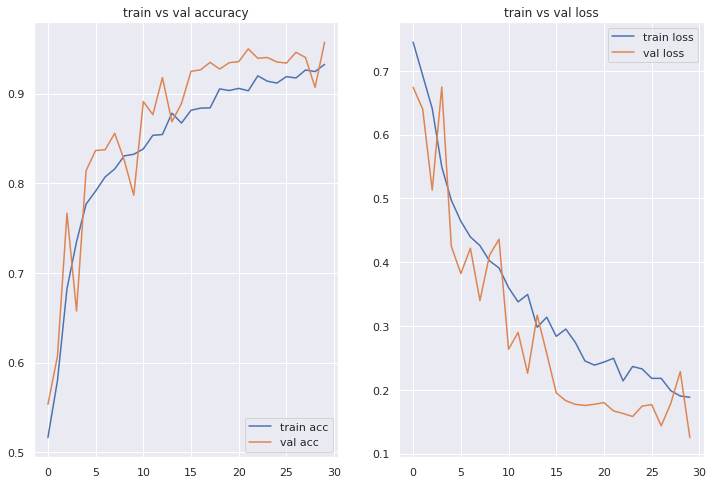

In [ ]:
#정확도
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

#오차 확인
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(30)

#accuracy 확인
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='train acc')
plt.plot(epochs_range,val_acc,label='val acc')
plt.legend(loc='lower right')
plt.title('train vs val accuracy')

#오차 확인
plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='train loss')
plt.plot(epochs_range,val_loss,label='val loss')
plt.legend()
plt.title('train vs val loss')

plt.show()

# 정확도 확인하기

In [ ]:
#test데이터 정확도 확인
test_loss, test_acc = model.evaluate(test_generator,verbose=2)#verbose는 그냥 출력문을 어떤식으로 보여줄까 묻는거 0은 출력문 안보여줌 1은 반만 2는 전체 다 출력

print('\n테스트 정확도:', test_acc)
print('\n테스트 손실값"',test_loss)

250/250 - 21s - loss: 0.1351 - accuracy: 0.9501 - 21s/epoch - 85ms/step

테스트 정확도: 0.9501459002494812

테스트 손실값" 0.1350712925195694


In [ ]:
#validation데이터 정확도 확인

test_loss, test_acc = model.evaluate(val_generator,verbose=2)#verbose는 그냥 출력문을 어떤식으로 보여줄까 묻는거 0은 출력문 안보여줌 1은 반만 2는 전체 다 출력

print('\n테스트 정확도:', test_acc)
print('\n테스트 손실값"',test_loss)

8/8 - 1s - loss: 0.2553 - accuracy: 0.8902 - 1s/epoch - 169ms/step

테스트 정확도: 0.8901734352111816

테스트 손실값" 0.2552792727947235


In [ ]:
predict_x=model.predict(val_generator) 
classes_x=np.argmax(predict_x,axis=1)
classes_x.shape

(346,)

In [ ]:
classes_x

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
ypred=model.predict(train_generator)
ypred[:10]

array([[0.01624191],
       [0.00329569],
       [0.03296143],
       [0.00222338],
       [0.00252171],
       [0.00322284],
       [0.9999882 ],
       [0.06633647],
       [0.9997564 ],
       [0.07401702]], dtype=float32)

# 저장된 모델 불러오기

In [ ]:
#모델 불러오기
from keras.models import load_model
model = load_model('/content/drive/MyDrive/데이터저장/모델저장/이걸로하기man or woman epoch 추가데이터 30, batch=48 teps=70 val=50.h5')

In [ ]:
#test데이터 정확도 확인
test_loss, test_acc = model.evaluate(test_generator,verbose=2)#verbose는 그냥 출력문을 어떤식으로 보여줄까 묻는거 0은 출력문 안보여줌 1은 반만 2는 전체 다 출력

print('\n테스트 정확도:', test_acc)
print('\n테스트 손실값"',test_loss)

250/250 - 28s - loss: 0.1351 - accuracy: 0.9501 - 28s/epoch - 112ms/step

테스트 정확도: 0.9501459002494812

테스트 손실값" 0.1350712776184082


# 시각화

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

#방법1
for fn in uploaded.keys():

  path='/content/' + fn
  img=image.load_img(path, target_size=(img_height, img_width))

  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  print(classes[0])

  if classes[0]>0.5:
    print(fn + " is a woman")# 1. 0. 남자
  else:
    print(fn + " is a man")#0. 1. 여자

Saving 태희.png to 태희.png
[0.]
태희.png is a man


In [ ]:
#방법2.1
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import cv2

def pred_img2(img,i):
  plt.subplot(5,5,i+1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  
  plt.axis('off')
  plt.show()

  img_resized=cv2.resize(img,(img_height,img_width))#모델에 들어가는 이미지 크기가 224*224 이기때문에 224*244로 이미지 크기를 조정해줌
  pred=model.predict(img_resized.reshape([1,img_height,img_width,3]))#예측을 할건데 모델.predict(위에서 이미지 크기를 조정한 이미지를 넣고 reshape()로 재배치를 시킨 값을 넣는다.)
  print(pred[0])

  if(pred[0]>0.5):
    print('woman')
  else:
    print('man')

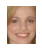

[0.9999999]
woman


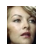

[0.]
man


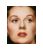

[0.]
man


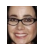

[5.8260487e-33]
man


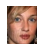

[0.]
man


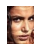

[0.]
man


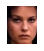

[1.9160788e-36]
man


In [ ]:
#이미지 확인
img=[]
for name in train_woman_fnames[:7]:
  img_data=cv2.imread(train_woman_dir+'/'+name)
  img.append(img_data)
for j,data in enumerate(img):
  pred_img2(data,j)

# 시각화2

In [ ]:
#방법2
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import cv2

def pred_img(img):
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

  img_resized=cv2.resize(img,(img_height,img_width))#모델에 들어가는 이미지 크기가 224*224 이기때문에 224*244로 이미지 크기를 조정해줌
  pred=model.predict(img_resized.reshape([1,img_height,img_width,3]))#예측을 할건데 모델.predict(위에서 이미지 크기를 조정한 이미지를 넣고 reshape()로 재배치를 시킨 값을 넣는다.)
  print(pred[0])

  if(pred[0]>0.5 or pred[0]==1):
    print('woman')
  elif(pred[0]<0.5 or pred[0]==0):
    print('man')

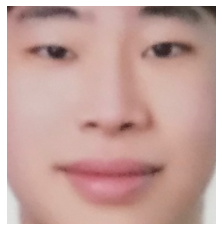

[2.3560906e-27]
man


In [ ]:
#내 증명사진
#289,346 664,738
src=cv2.imread('/content/증명사진.jpg',cv2.IMREAD_UNCHANGED)

dst=src[346:738,289:664].copy()

plt.imshow(dst)
plt.axis('off')

pred_img(dst)

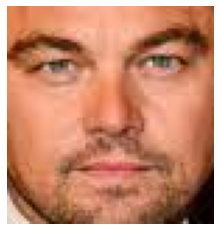

[0.]
man


In [ ]:
#디카프리오 48:155,52:130
#55,72 129,150
src=cv2.imread('/content/디카프리오.jfif',cv2.IMREAD_UNCHANGED)

dst=src[72:150,55:129].copy()

plt.imshow(dst)
plt.axis('off')

pred_img(dst)

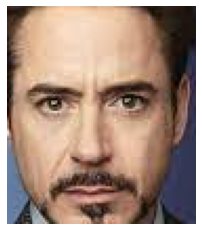

[0.]
man


In [ ]:
#로다주 93,40 183,144
src=cv2.imread('/content/로다주.jpg',cv2.IMREAD_UNCHANGED)

dst=src[40:144,93:183].copy()

plt.imshow(dst)
plt.axis('off')

pred_img(dst)

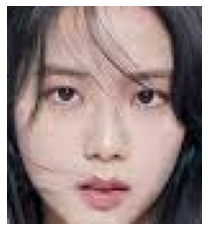

[0.9999975]
woman


In [ ]:
#지수 46,37 122,122
src=cv2.imread('/content/지수이미지.jfif',cv2.IMREAD_UNCHANGED)

dst=src[37:122,46:122].copy()

plt.imshow(dst)
plt.axis('off')

pred_img(dst)

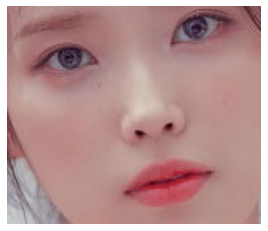

[0.]
man


In [ ]:
#아이유 139,102 332,304
#153,151 321,295
src=cv2.imread('/content/여자이미지.jpg',cv2.IMREAD_UNCHANGED)

dst=src[151:295,153:321].copy()

plt.imshow(dst)
plt.axis('off')

pred_img(dst)

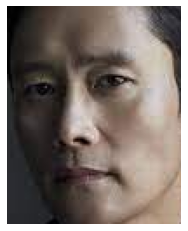

[0.]
man


In [ ]:
#이병헌 38,65 138,190
src=cv2.imread('/content/이병헌남자이미지.jfif',cv2.IMREAD_UNCHANGED)

dst=src[65:190,38:138].copy()

plt.imshow(dst)
plt.axis('off')

pred_img(dst)

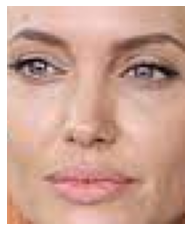

[6.3024075e-36]
man


In [ ]:
#졸리 55,41 132,164
#54,69 121,151
src=cv2.imread('/content/안젤리나졸리.jfif',cv2.IMREAD_UNCHANGED)

dst=src[69:151,54:121].copy()

plt.imshow(dst)
plt.axis('off')

pred_img(dst)

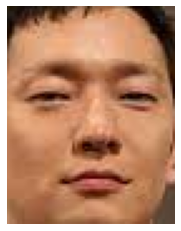

[0.]
man


In [ ]:
#손석구 113,35 180,122
src=cv2.imread('/content/손석구 이미지.jfif',cv2.IMREAD_UNCHANGED)

dst=src[35:122,113:180].copy()

plt.imshow(dst)
plt.axis('off')

pred_img(dst)

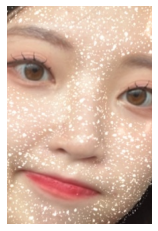

[0.9998925]
woman


In [ ]:
#여자사진 308,404 524,730
src=cv2.imread('/content/은희사진.jpg',cv2.IMREAD_UNCHANGED)

dst=src[404:730,308:524].copy()

plt.imshow(dst)
plt.axis('off')

pred_img(dst)

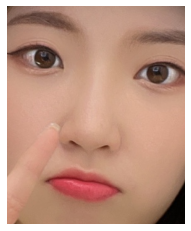

[0.9987256]
woman


In [ ]:
#여자사진 726,442  1014,795
src=cv2.imread('/content/은희사진2.jpg',cv2.IMREAD_UNCHANGED)

dst=src[442:795,726:1014].copy()

plt.imshow(dst)
plt.axis('off')

pred_img(dst)

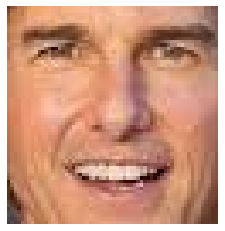

[0.]
man


In [ ]:
#톰크루즈 112,61 174,125
src=cv2.imread('/content/톰크루즈.jfif',cv2.IMREAD_UNCHANGED)

dst=src[61:125,112:174].copy()

plt.imshow(dst)
plt.axis('off')

pred_img(dst)

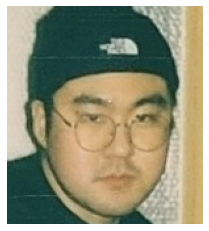

ValueError: ignored

In [ ]:
#태희
src=cv2.imread('/content/태희.jpg',cv2.IMREAD_UNCHANGED)

dst=src.copy()

plt.imshow(dst)
plt.axis('off')

pred_img(dst)

# 시긱화3

In [ ]:
import cv2
import glob

test_img_list=[]

test_img_name_list=glob.glob('test_image_dir/*')

for i in range(len(test_img_name_list)):
    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(img_width, img_height))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    src_img = src_img / 255.0

    test_img_list.append(src_img)

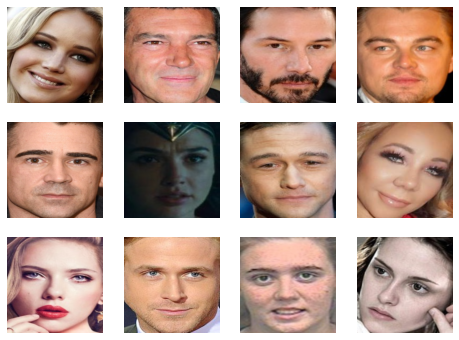

In [ ]:
plt.figure(figsize=(8,6))

for i in range(len(test_img_list)):
  plt.subplot(3,4,i+1)
  plt.axis('off')
  plt.imshow(test_img_list[i])

plt.show()

In [ ]:
for i in range(len(test_img_list)):
  print(test_img_list[i].shape)

(250, 250, 3)
(250, 250, 3)
(250, 250, 3)
(250, 250, 3)
(250, 250, 3)
(250, 250, 3)


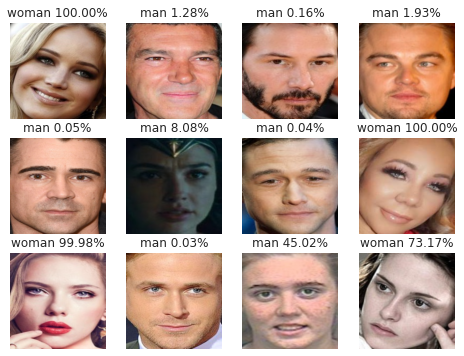

In [ ]:
pred=model.predict(np.array(test_img_list))

class_name=['man','woman']

plt.figure(figsize=(8,6))

for i in range(len(test_img_list)):
  plt.subplot(3,4,i+1)

  
  probility='{0:0.2f}'.format(100*max(pred[i]))
  if(pred[i]>0.5):
    title_str= 'woman '+probility+'%'
    plt.title(title_str)
  else:
    title_str= 'man '+probility+'%'
    plt.title(title_str)

  plt.imshow(test_img_list[i])
  plt.axis('off')
plt.show()

In [ ]:
print('hi')

In [ ]:
print('hi')